# Day 0: Mission Data Simulation

We will be generating a synthetic dataset (mission_data.csv) that contains records of fictional space missions — each row is a mission, each column is a feature (e.g., crew size, fuel level, solar flare risk).

We're also simulating the outcome of each mission (success/failure, or score %) using rules and randomness — just like real-world systems that are partly predictable, partly chaotic.

## Import and Reproducibility Set-Up

In [67]:
# Basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)  # Reproducibility


## Generate Mission Data

In [68]:
# Simulate data
np.random.seed(42)
n = 500

# --- BASE FEATURES ---
# These are the independent variables that form the basis of the simulation.

# Mission ID
mission_id = [f"MSN_{i:04d}" for i in range(n)]

# Crew Size: Integer between 3 and 9.
crew_size = np.random.randint(3, 10, n)

# Mission Type: A categorical variable for classification tasks.
# We'll create a slight imbalance in the mission types.
mission_type_choices = ["Exploration", "Resupply", "Rescue"]
mission_type = np.random.choice(mission_type_choices, n, p=[0.5, 0.3, 0.2])

# Distance to Target (in million km): Base for several other features.
# Made the mean larger for a more "interplanetary" feel.
distance_km = np.random.normal(loc=500, scale=150, size=n)
distance_km = np.clip(distance_km, 50, 1000) # Ensure realistic bounds

# Solar Flare Risk: A beta distribution is great for values between 0 and 1.
# Represents the probability of a significant solar event during the mission.
solar_flare_risk = np.random.beta(2, 5, n)


# --- ENGINEERED & CORRELATED FEATURES ---
# These features are derived from the base features, introducing complexity
# like multicollinearity, non-linear relationships, and interaction terms.

# Mission Duration (in Earth days): Linearly dependent on distance, with some noise.
# This creates multicollinearity with `distance_km`.
mission_duration = 2.5 * distance_km + np.random.normal(0, 25, n)

# Fuel Capacity (in kg): Correlated with distance and mission duration.
fuel_capacity = 1.2 * distance_km + 0.5 * mission_duration + np.random.normal(0, 100, n)

# Payload Mass (in kg): Intentionally correlated with fuel_capacity.
# This adds another layer of multicollinearity.
payload_mass = 0.6 * fuel_capacity + np.random.normal(0, 50, n)

# Crew Mental Health Score: A simulated pre-flight psychological assessment score (0 to 1).
# We will introduce missing values here later.
mental_health_score = np.random.normal(loc=0.8, scale=0.15, size=n)
mental_health_score = np.clip(mental_health_score, 0, 1)

# Mission Cost (in millions): A complex feature for utility-based decision making.
# Cost depends on duration, crew size, and mission type. Rescue missions are more expensive.
type_cost_multiplier = np.select(
    [mission_type == "Exploration", mission_type == "Resupply", mission_type == "Rescue"],
    [1.2, 0.8, 2.0]
)
mission_cost = (50 + 0.1 * mission_duration + 5 * crew_size) * type_cost_multiplier + np.random.normal(0, 10, n)


# --- TARGET VARIABLES & OUTCOMES ---
# These are the dependent variables that students will try to predict.

# 1. Continuous Target: Mission Success Score (0-100)
# This is the core of the regression task. It includes:
# - Linear terms (distance, fuel)
# - A non-linear (polynomial) term for mental health.
# - An interaction term between solar flare risk and mission duration.
# - A categorical effect from mission_type.
# - Noise to ensure the relationship isn't deterministic.

# Define effect of mission type on success
type_success_effect = np.select(
    [mission_type == "Exploration", mission_type == "Resupply", mission_type == "Rescue"],
    [-15, 10, -30] # Rescue missions are inherently riskier
)

# Calculate raw success score
success_score = (
    150 +
    -0.35 * distance_km +                       # Negative: Longer distances are harder
    0.25 * fuel_capacity +                     # Positive: More fuel is better
    0.02 * payload_mass +                      # Positive: Heavier payload could mean more science gear
    250 * mental_health_score +                # Strong positive linear term
    -150 * (mental_health_score - 0.8)**2 +    # POLYNOMIAL: Optimal score is around 0.8
    -0.05 * solar_flare_risk * mission_duration + # INTERACTION: Flares are worse on long missions
    type_success_effect +                      # Categorical effect
    np.random.normal(loc=0, scale=15, size=n)  # Random noise
)

# Normalize and clip to a 0-100 scale
mission_success_score = np.clip((success_score / 400) * 100, 0, 100)


# 2. Binary Target: Mission Outcome
# Derived from the success score. This is for binary classification.
mission_outcome = np.where(mission_success_score > 60, "Success", "Failure")


# 3. Binary Anomaly Detection with Class Imbalance
# Represents a critical system anomaly during the mission.
# The 90/10 split is ideal for teaching about precision, recall, and F1-score.
anomaly_detected = np.random.choice([0, 1], size=n, p=[0.9, 0.1])


# --- INTRODUCE MISSING DATA ---
# To simulate real-world data, we'll randomly insert `NaN` values.
# This is a crucial step for teaching data imputation techniques.

# Introduce ~10% missing values in `mental_health_score`
mh_nan_indices = np.random.choice(n, size=int(n * 0.1), replace=False)
mental_health_score[mh_nan_indices] = np.nan

# Introduce ~5% missing values in `payload_mass`
pm_nan_indices = np.random.choice(n, size=int(n * 0.05), replace=False)
payload_mass[pm_nan_indices] = np.nan


## Create DataFrame

In [69]:
# Assemble Dataframe

mission_df = pd.DataFrame({
    'mission_id': mission_id,
    'mission_type': mission_type,
    'crew_size': crew_size,
    'mission_duration_days': mission_duration.round(1),
    'distance_to_target_km': distance_km.round(2),
    'fuel_capacity_kg': fuel_capacity.round(2),
    'payload_mass_kg': payload_mass.round(2),
    'mental_health_score': mental_health_score.round(3),
    'solar_flare_risk': solar_flare_risk.round(3),
    'mission_cost_millions': mission_cost.round(2),
    'anomaly_detected': anomaly_detected,
    'mission_success_score': mission_success_score.round(2),
    'mission_outcome': mission_outcome
})


mission_df.head()

,mission_id,mission_type,crew_size,mission_duration_days,distance_to_target_km,fuel_capacity_kg,payload_mass_kg,mental_health_score,solar_flare_risk,mission_cost_millions,anomaly_detected,mission_success_score,mission_outcome
0,MSN_0000,Exploration,9,1173.0,459.67,1188.05,725.61,0.640,0.319,254.79,0,100.0,Success
1,MSN_0001,Resupply,6,1059.0,434.02,1066.20,618.12,NaN,0.235,161.03,0,100.0,Success
2,MSN_0002,Exploration,7,1464.7,596.50,1411.42,810.49,0.767,0.045,261.06,0,100.0,Success
3,MSN_0003,Rescue,9,1833.2,734.71,1895.24,1220.50,0.791,0.199,574.26,0,100.0,Success
4,MSN_0004,Exploration,5,1678.2,680.75,1535.50,927.37,0.874,0.375,290.14,0,100.0,Success


**Feature Description: Mission Data Dictionary**

| Feature Name | Description | Unit / Type |
| :--- | :--- | :--- |
| `mission_id` | Unique identifier for each mission. | `string` |
| `mission_type` | The primary objective of the mission. | `string` (Exploration, Resupply, Rescue) |
| `crew_size` | The number of astronauts on board. | `integer` (persons) |
| `mission_duration_days` | The total duration of the mission. | `float` (days) |
| `distance_to_target_km` | The distance from Earth to the mission's target. | `float` (million km) |
| `fuel_capacity_kg` | The total amount of fuel loaded for the mission. | `float` (kilograms) |
| `payload_mass_kg` | The mass of the mission's payload (e.g., supplies, satellites). | `float` (kilograms) |
| `mental_health_score` | A pre-flight psychological fitness score for the crew. | `float` (0 to 1 score) |
| `solar_flare_risk` | The estimated probability of a significant solar flare event. | `float` (0 to 1 probability) |
| `mission_cost_millions`| The total operational cost of the mission. | `float` (millions of USD) |
| `anomaly_detected` | Whether a critical system anomaly was detected during the mission. | `integer` (0 = No, 1 = Yes) |
| `mission_success_score`| An overall score representing the mission's success. | `float` (0 to 100) |
| `mission_outcome` | The final binary outcome of the mission. | `string` (Success, Failure) |


## Visualize Key Features

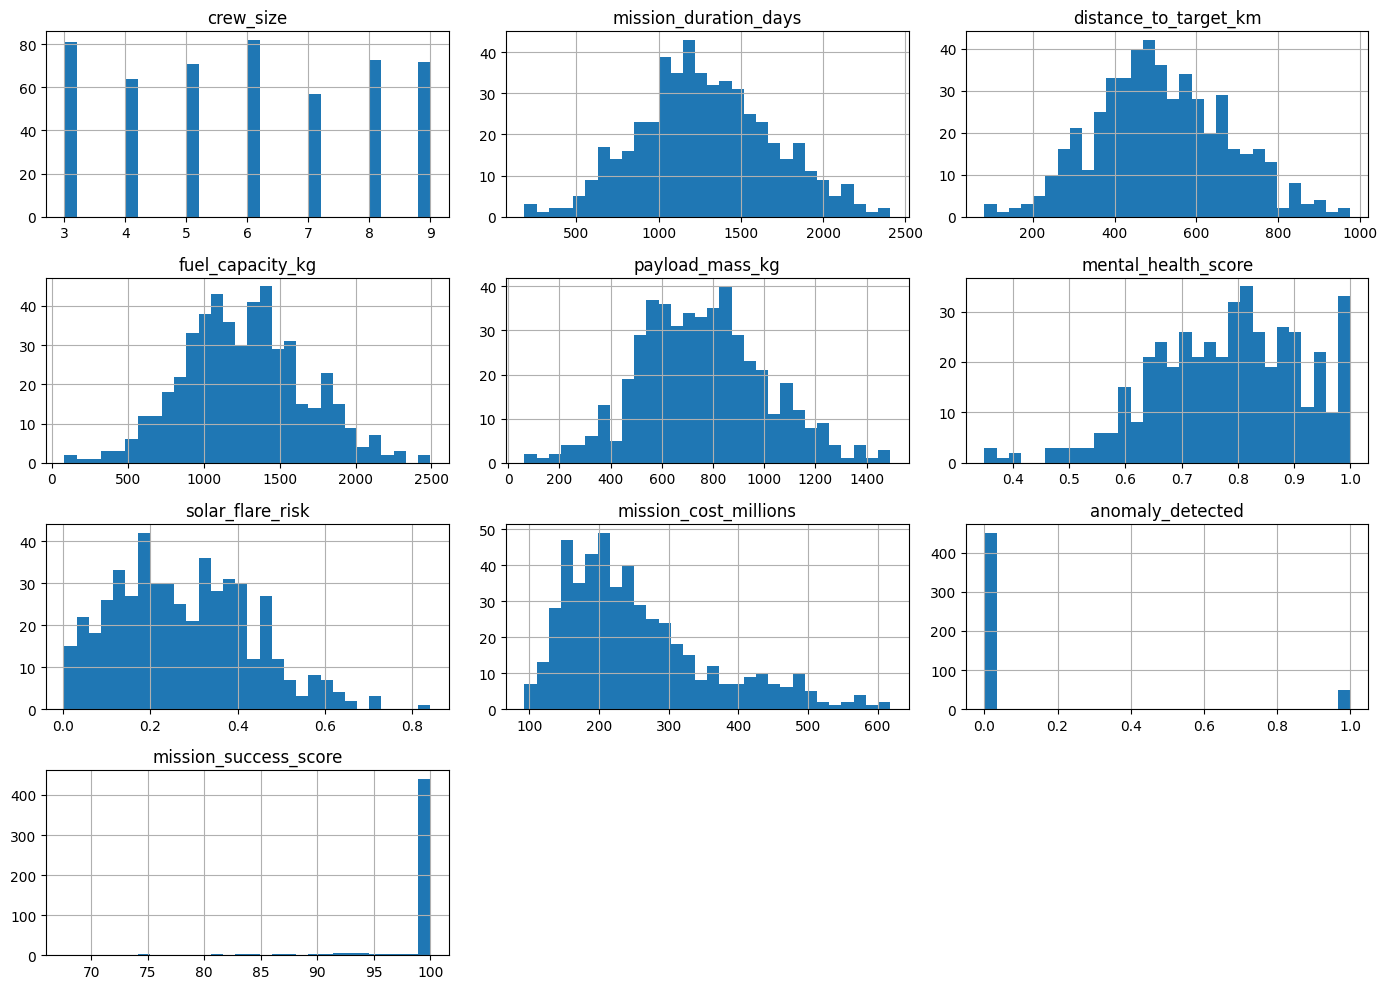

In [70]:
# Quick overview
mission_df.describe()

# Histograms
mission_df.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()

## Pair Plot
This helps visually explore relationships between multiple features in your dataset.

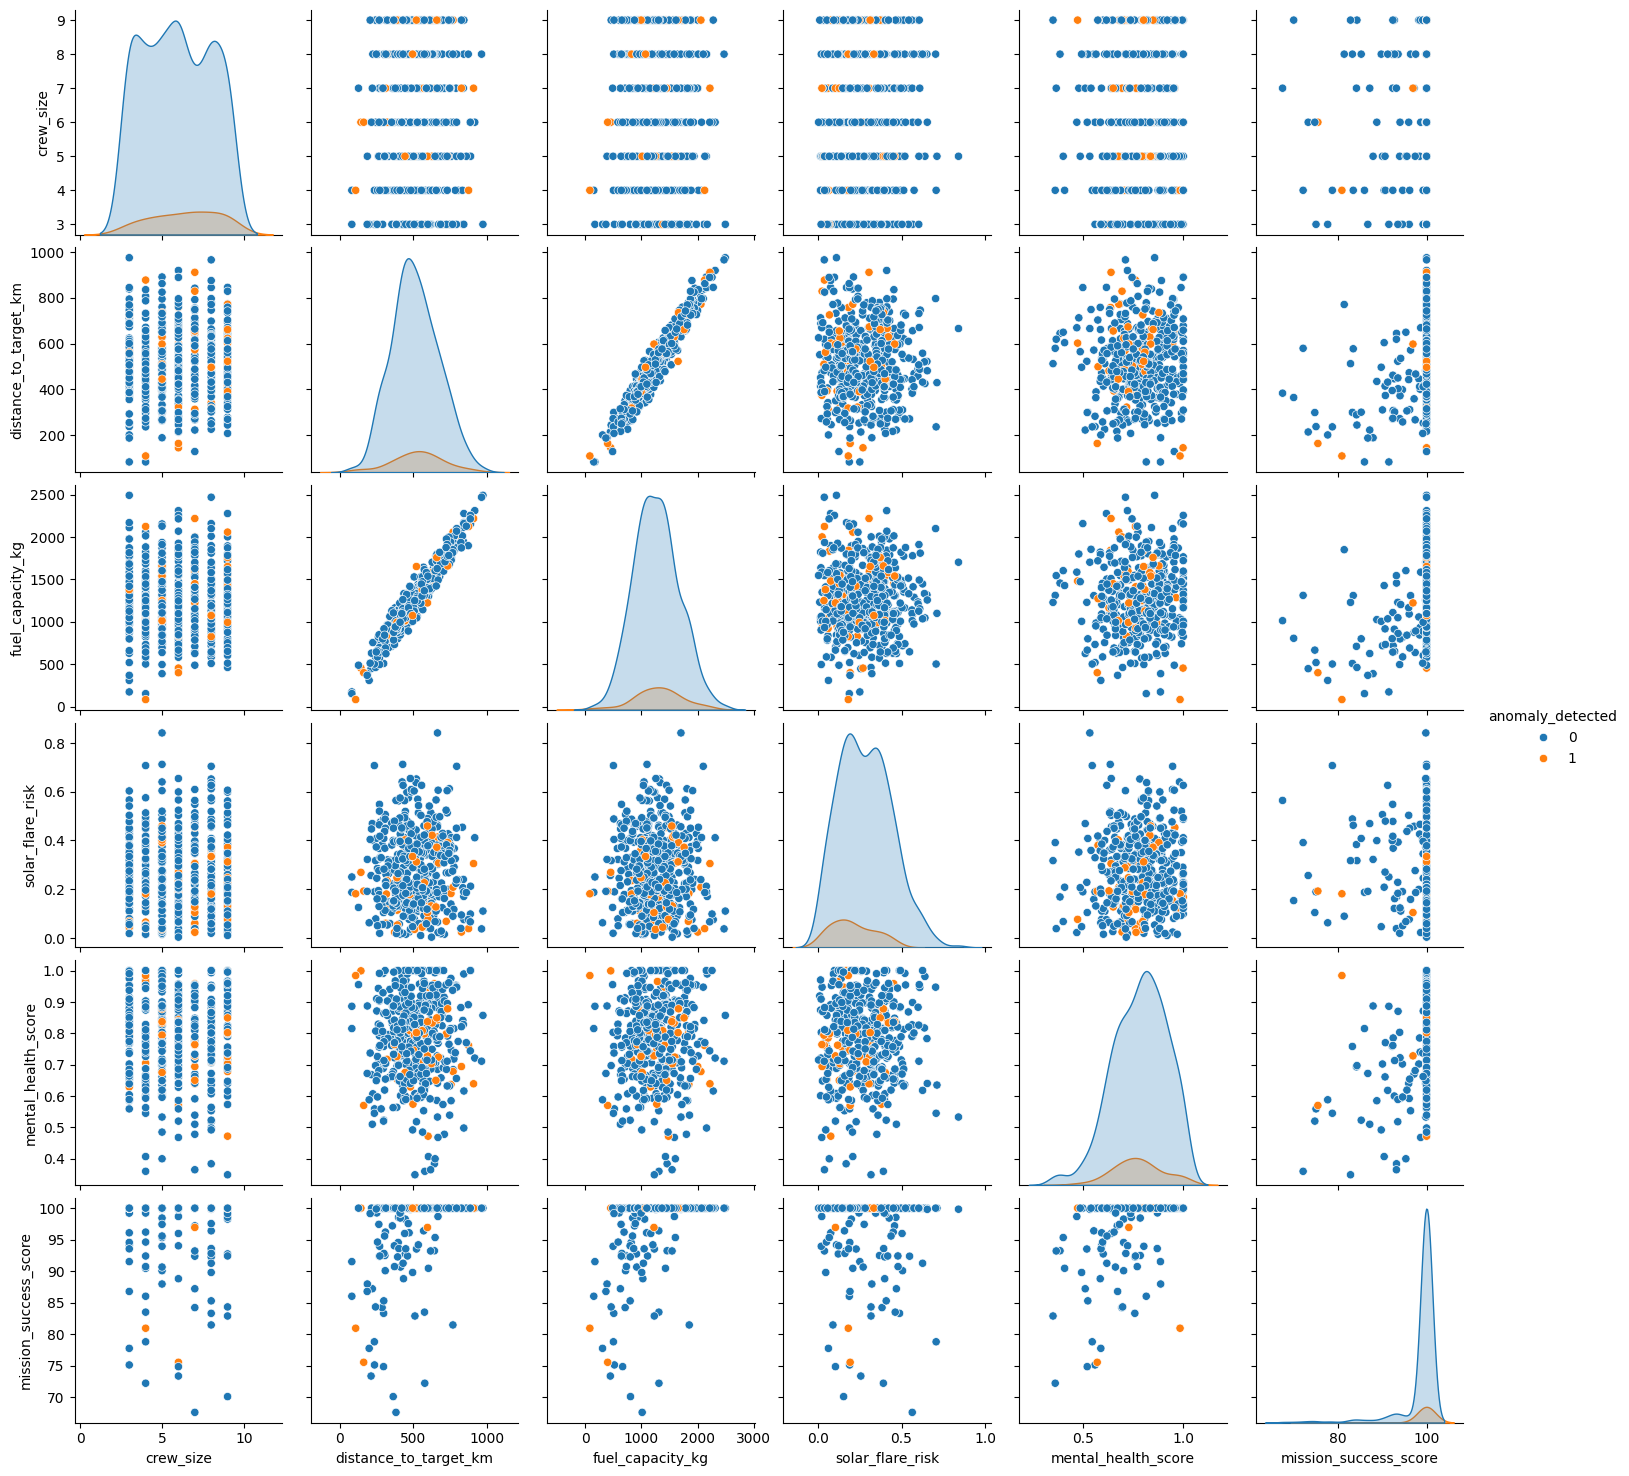

In [71]:
# Select a few relevant features
sns.pairplot(mission_df[[
    "crew_size", "distance_to_target_km", "fuel_capacity_kg", 
    "solar_flare_risk", "mental_health_score", 
    "anomaly_detected", "mission_success_score"
]], hue="anomaly_detected")
plt.show()

## Save as CSV

In [72]:
# Save to /data folder
import os
os.makedirs("data", exist_ok=True)
mission_df.to_csv("data/mission_data.csv", index=False)

print("Done. Saved.")

Done. Saved.


## Reflection: Why Simulate Mission Data?

This dataset is our foundation. It is a fictional, structured representation of what an AI system might learn from in a real mission control environment.

By designing the data ourselves, we not only control the complexity and relationships between variables, but also gain intuition about what impacts outcomes — like how fuel, mental health, or anomalies affect mission success.

In the next few days, we’ll use this dataset to build increasingly intelligent models that learn from these patterns and make meaningful predictions.

Let the mission begin! 